# Final Project, IS 620

## Ranking Centrality of Senators and Bills -- Why?

In this script, we will rank the centrality of senators and bills associated with the 115th Congress of the United States of America.  We define centrality in terms of the number of links via bill sponsorship.  For example, a bill could be considered more highly central if it has 20 cosponsors rather than a single sponsor.  A senator could be considered more central if s/he is linked to 20 other senators via cosponsoring bills with them, rather than not sponsoring bills with anyone else, or by simply counting the number of bill sponsorships.

Note that this kind of centrality measure is not taking into account very significant elements of senatorial influence:

* length of time in office
* being a junior or senior rank within the state
* membership in key committees
* amount of press coverage
* etc.

We are simply ranking senators by prolificness -- how much are different senators contributing to the senate's legislative docket? 

Similarly, bills could have their relative importance measured by a number of factors we're intentionally leaving out -- things like

* the amount of press coverage received
* the likelihood of passage
* its partisan strength / divisiveness
* its economic impact
* etc.


### Import Needed Packages

In [37]:
import requests
import json
import networkx as net
import networkx.algorithms.bipartite as bipartite
import pandas as pd
import time
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline

### Set Up Function to Use ProPublica Congress API

In [2]:
def propublica(url):
    r = requests.get(url, headers={'X-API-Key': '***REDACTED***'})  
    data = json.loads(r.text)
    return (data)

### Get List of Senators from Propublica API

In [3]:
senators = propublica("https://api.propublica.org/congress/v1/115/senate/members.json")['results'][0]['members']
senators[:] = [d for d in senators if d.get('last_name') != 'Sessions']  # Jeff Sessions no longer Senator
senators[:] = [d for d in senators if d.get('last_name') != 'Franken']   # Al Franken no longer Senator
df_senators = pd.DataFrame(senators)
df_senators.head()

,api_uri,contact_form,crp_id,cspan_id,date_of_birth,dw_nominate,facebook_account,fax,fec_candidate_id,first_name,...,state_rank,suffix,title,total_present,total_votes,twitter_account,url,votes_with_party_pct,votesmart_id,youtube_account
0,https://api.propublica.org/congress/v1/members...,http://www.alexander.senate.gov/public/index.c...,N00009888,5,1940-07-03,0.323,senatorlamaralexander,202-228-3398,S2TN00058,Lamar,...,senior,None,"Senator, 2nd Class",0,309,SenAlexander,https://www.alexander.senate.gov/public/,97.97,15691,lamaralexander
1,https://api.propublica.org/congress/v1/members...,https://www.baldwin.senate.gov/feedback,N00004367,57884,1962-02-11,-0.546,TammyBaldwin,202-225-6942,S2WI00219,Tammy,...,junior,None,"Senator, 1st Class",1,309,SenatorBaldwin,https://www.baldwin.senate.gov/,96.12,3470,witammybaldwin
2,https://api.propublica.org/congress/v1/members...,https://www.barrasso.senate.gov/public/index.c...,N00006236,1024777,1952-07-21,0.528,johnbarrasso,202-224-1724,S6WY00068,John,...,junior,None,"Senator, 1st Class",0,309,SenJohnBarrasso,https://www.barrasso.senate.gov/,98.38,52662,barrassowyo
3,https://api.propublica.org/congress/v1/members...,https://www.bennet.senate.gov/?p=contact,N00030608,1031622,1964-11-28,-0.208,senbennetco,202-228-5097,S0CO00211,Michael,...,senior,None,"Senator, 3rd Class",1,309,SenBennetCo,https://www.bennet.senate.gov/,92.53,110942,SenatorBennet
4,https://api.propublica.org/congress/v1/members...,https://www.blumenthal.senate.gov/contact/,N00031685,21799,1946-02-13,-0.418,SenBlumenthal,202-224-9673,S0CT00177,Richard,...,senior,None,"Senator, 3rd Class",1,309,SenBlumenthal,https://www.blumenthal.senate.gov/,91.88,1568,SenatorBlumenthal


### Get Recent Active Bills

The API will only send 20 at a go, so we have to paginate!

In [4]:
url = "https://api.propublica.org/congress/v1/115/senate/bills/active.json?offset="
offset = 0
apiResults = propublica(url + str(offset))
activeBills = apiResults['results'][0]['bills']
while True:
    offset = offset + 20
    apiResults = propublica(url + str(offset))
    moreBills = apiResults['results'][0]['bills']
    if len(moreBills) == 0:
        break
    activeBills += moreBills
    time.sleep(.25)  # Be friendly and don't overwhelm the server with a bunch of fast queries

In [5]:
df_activebills = pd.DataFrame(activeBills)
df_activebills.head()

,active,bill_id,bill_slug,bill_type,bill_uri,committee_codes,committees,congressdotgov_url,cosponsors,cosponsors_by_party,...,sponsor_name,sponsor_party,sponsor_state,sponsor_title,sponsor_uri,subcommittee_codes,summary,summary_short,title,vetoed
0,True,s2199-115,s2199,s,https://api.propublica.org/congress/v1/115/bil...,[],,https://www.congress.gov/bill/115th-congress/s...,0,{},...,Jeff Flake,R,AZ,Sen.,https://api.propublica.org/congress/v1/members...,[],,,A bill to authorize appropriations for border ...,None
1,True,s2192-115,s2192,s,https://api.propublica.org/congress/v1/115/bil...,[],,https://www.congress.gov/bill/115th-congress/s...,5,{u'R': 5},...,Charles E. Grassley,R,IA,Sen.,https://api.propublica.org/congress/v1/members...,[],,,"A bill to strengthen border security, increase...",None
2,True,s2146-115,s2146,s,https://api.propublica.org/congress/v1/115/bil...,"[SSFI, SLIA]",Senate Finance Committee,https://www.congress.gov/bill/115th-congress/s...,10,{u'D': 10},...,Tom Udall,D,NM,Sen.,https://api.propublica.org/congress/v1/members...,[],,,A bill to extend the full Federal medical assi...,None
3,True,s1266-115,s1266,s,https://api.propublica.org/congress/v1/115/bil...,"[HSVR, SSVA]",House Veterans&#39; Affairs Committee,https://www.congress.gov/bill/115th-congress/s...,3,"{u'R': 1, u'D': 2}",...,James M. Inhofe,R,OK,Sen.,https://api.propublica.org/congress/v1/members...,[],(This measure has not been amended since it wa...,(This measure has not been amended since it wa...,A bill to authorize the Secretary of Veterans ...,None
4,True,s371-115,s371,s,https://api.propublica.org/congress/v1/115/bil...,"[HSFA, SSFR]",House Foreign Affairs Committee,https://www.congress.gov/bill/115th-congress/s...,0,{},...,Bob Corker,R,TN,Sen.,https://api.propublica.org/congress/v1/members...,[],,,A bill to make technical changes and other imp...,None


Let's take a look at the number of cosponsors, visually:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b5c9f10>]], dtype=object)

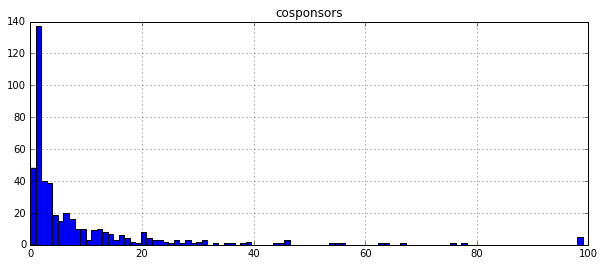

In [6]:
df_activebills.hist("cosponsors", bins = 100, figsize = [10, 4])

We notice a few things in this graphic.  

* Many bills (perhaps most) have 0-1 cosponsors.
* There's an odd uptick at 99 -- there are a few bills that seem to have universal agreement.
* There are a lot of "ties" of bills with the same number of sponsors.

It seems that ranking bills by number of senator cosponsorships alone (degree centrality) may not provide a lot of information.  We will want to get the relative importance of senators first, then include that in ranking the centrality of bills in a custom measure of centrality.

### Create a Graph of Senators and Bills Using NetworkX

First, we'll simplify our Senators and Bills data!

#### Simplify Senators

In [7]:
simplifiedSenators = [dict.fromkeys(["id", "first_name", "middle_name", "last_name", "party", \
                                     "seniority", "state_rank", "facebook_account", "twitter_account"])]

for senator in senators:
    simplifiedSenator = {key: senator[key] for key in senator if key in \
                      ['id','first_name','middle_name','last_name','party',\
                       'seniority','state_rank', "facebook_account", "twitter_account"]}
    simplifiedSenators.append(simplifiedSenator)

#### Remove "None" row
There'a a "none" first row that is going to cause a problem. I'll remove it.

In [8]:
simplifiedSenators.pop(0)
dfSenators = pd.DataFrame(simplifiedSenators).set_index('id')
dfSenators.head()

,facebook_account,first_name,last_name,middle_name,party,seniority,state_rank,twitter_account
id,,,,,,,,
A000360,senatorlamaralexander,Lamar,Alexander,None,R,15,senior,SenAlexander
B001230,TammyBaldwin,Tammy,Baldwin,None,D,5,junior,SenatorBaldwin
B001261,johnbarrasso,John,Barrasso,None,R,11,junior,SenJohnBarrasso
B001267,senbennetco,Michael,Bennet,None,D,9,senior,SenBennetCo
B001277,SenBlumenthal,Richard,Blumenthal,None,D,7,senior,SenBlumenthal


#### Simplify Bills, Remove "None" Row

In [9]:
simplifiedBills = [dict.fromkeys(['bill_slug','title','sponsor_id','primary_subject','sponsor_party'])]
for activeBill in activeBills:
    simplifiedBill = {key: activeBill[key] for key in activeBill if key in \
                      ['bill_slug','title', 'sponsor_id','primary_subject','sponsor_party']}
    simplifiedBills.append(simplifiedBill)
simplifiedBills.pop(0)
dfBills = pd.DataFrame(simplifiedBills).set_index('bill_slug')
dfBills.head()

,primary_subject,sponsor_id,sponsor_party,title
bill_slug,,,,
s2199,,F000444,R,A bill to authorize appropriations for border ...
s2192,,G000386,R,"A bill to strengthen border security, increase..."
s2146,Health,U000039,D,A bill to extend the full Federal medical assi...
s1266,Armed Forces and National Security,I000024,R,A bill to authorize the Secretary of Veterans ...
s371,International Affairs,C001071,R,A bill to make technical changes and other imp...


Now we have simplified data that's nice and clean.  Let's create a graph that links senators to the bills they sponsored.

In [10]:
g = net.Graph()
for senator in simplifiedSenators:
    # I want to distinguish between senators and bills, so I'll add this "bipartite" attribute.
    g.add_node(senator['id'], attr_dict=senator, bipartite=0)  
for bill in simplifiedBills:
    # I want to distinguish between senators and bills, so I'll add this "bipartite" attribute.
    g.add_node(bill['bill_slug'], attr_dict=bill, bipartite = 1)
        # we removed some senators so only add edges to folks who are still senators!
    if bill['sponsor_id'] in g:
        g.add_edge(bill['sponsor_id'],bill['bill_slug'])

#### Get Bill Cosponsors

Bills also have cosponsors, in some cases, so we should have those links in place as well! 

##### Get Cosponsored Bills

In [11]:
df_activeBills = pd.DataFrame(activeBills)
cosponsoredBills = df_activeBills
cosponsoredBills = cosponsoredBills[['bill_slug','sponsor_id', 'cosponsors']]
cosponsoredBills.head()

,bill_slug,sponsor_id,cosponsors
0,s2199,F000444,0
1,s2192,G000386,5
2,s2146,U000039,10
3,s1266,I000024,3
4,s371,C001071,0


##### Create Edges for Cosponsorship

In [12]:
g = net.Graph()
for senator in simplifiedSenators:
    # I want to distinguish between senators and bills, so I'll add this "bipartite" attribute.
    g.add_node(senator['id'], attr_dict=senator, bipartite=0)  
for bill in simplifiedBills:
    # I want to distinguish between senators and bills, so I'll add this "bipartite" attribute.
    g.add_node(bill['bill_slug'], attr_dict=bill, bipartite = 1)
    # we removed some senators so only add edges to folks who are still senators!
    if bill['sponsor_id'] in g:
        g.add_edge(bill['sponsor_id'],bill['bill_slug'])

What we've done above is address primary sponsorship.  Now we have to look up the info on each cosponsored bill (at least the ones that have at least one cosponsor), collect all the cosponsors of that bill and link cosponsors to the bills they cosponsored with edges.

In [13]:
for index, row in cosponsoredBills[(cosponsoredBills['cosponsors'] > 0)].iterrows():
    cosponsorInfo = pd.DataFrame(propublica("https://api.propublica.org/congress/v1/115/bills/" + \
                                            row['bill_slug'] + "/cosponsors.json")\
                                            ['results'][0]['cosponsors'])
    for cosponsor in cosponsorInfo['cosponsor_id']: # for each cosponsor
        # we removed some senators so only add edges to folks who are still senators!
        if cosponsor in g:
            g.add_edge(cosponsor,row['bill_slug'], bipartite=1) # link cosponsoring Senator to the bill

#### Graph attractively
First we want to make sure that senators and bills are separate node lists, so we can plot them in different colors. We'll make the node size dependent on the degree of each node!

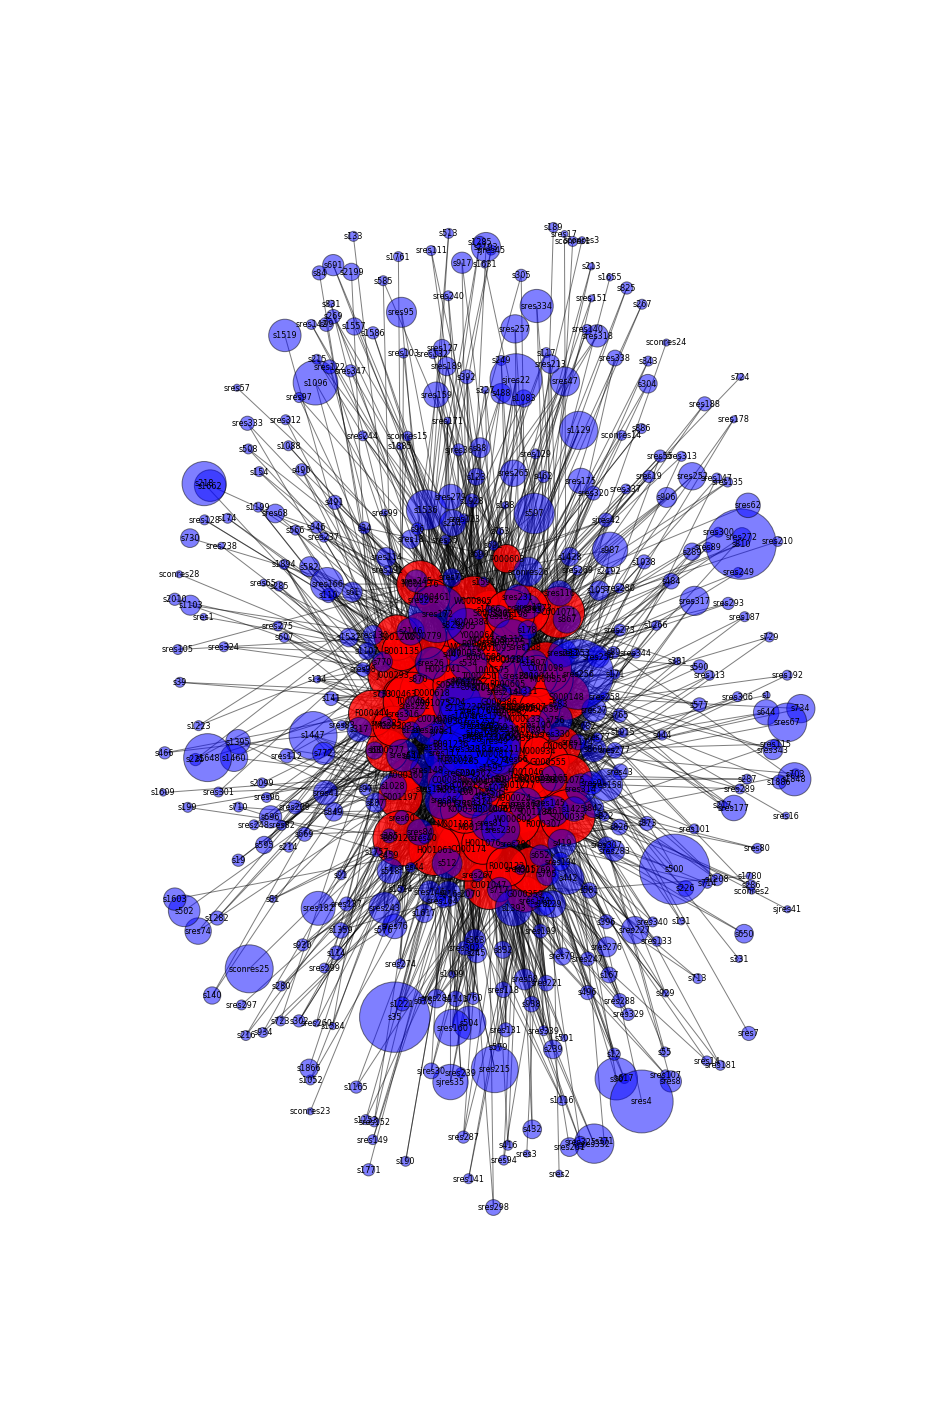

In [14]:
senators, bills = bipartite.sets(g)
import matplotlib.pyplot as plt
%matplotlib inline

pos=net.spring_layout(g, k=0.4) # positions for all nodes, nicely spread apart.

# calculate degree centrality
senatorDegree = net.degree(g, senators) 
billDegree = net.degree(g, bills)

plt.figure(1,figsize=(16,25)) 

# nodes
net.draw_networkx_nodes(g,pos,
                       nodelist=senators,
                       node_color='r',
                       node_size=[v * 50 for v in senatorDegree.values()],
                   alpha=0.8)
net.draw_networkx_nodes(g,pos,
                       nodelist=bills,
                       node_color='b',
                       node_size=[v * 50 for v in billDegree.values()],
                   alpha=0.5)

# edges
net.draw_networkx_edges(g,pos,width=1.0,alpha=0.5)
net.draw_networkx_labels(g,pos,font_size=8,font_family='sans-serif')
plt.axis('off')
plt.show() # display

Wow, that's really complex!  Let's project all of that onto senators in order to simplify matters.  We're going to choose eigenvector centrality, because there are bills that every senator sponsored, so degree centrality would give the same measure for each senator.  This also means that a graph will be very cluttered looking -- everyone connects to everyone else.  We can skip the graph visualization for this reason.  We will, however, plot a histogram of the eigencentrality calculation to see the distribution of senate centrality.

(array([  2.,   1.,   4.,   3.,   3.,   2.,   3.,   3.,   7.,   8.,   3.,
          7.,  10.,   3.,   9.,   7.,   7.,   4.,   3.,   2.,   3.,   1.,
          0.,   3.,   1.]),
 array([ 0.05314113,  0.05687402,  0.06060691,  0.0643398 ,  0.06807269,
         0.07180558,  0.07553848,  0.07927137,  0.08300426,  0.08673715,
         0.09047004,  0.09420293,  0.09793582,  0.10166871,  0.10540161,
         0.1091345 ,  0.11286739,  0.11660028,  0.12033317,  0.12406606,
         0.12779895,  0.13153185,  0.13526474,  0.13899763,  0.14273052,
         0.14646341]),
 <a list of 25 Patch objects>)

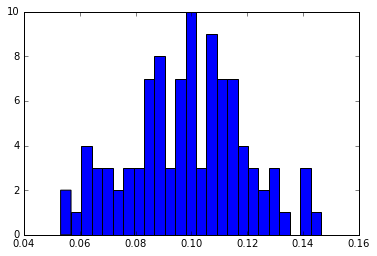

In [15]:
s = bipartite.weighted_projected_graph(g, senators)
senate_eigen_centrality = net.eigenvector_centrality(s, weight='weight')
plt.hist( senate_eigen_centrality.values(), bins=25)

Great, we have some clearly less central senators and some highly central senators, and a bunch in the middle.  We now have measures for senators, which we can rank in terms of centrality.  We can also use this centrality measure to assist in calculating centrality for bills!  Bills that are cosponsored by relatively weakly central senators will not rank as highly as bills that are cosponsored by strongly central senators.

What is the ranking of our Senators?

In [16]:
dfSenators = pd.concat([dfSenators, pd.Series(senate_eigen_centrality, name="centrality")], axis=1)
dfSenators['centrality_rank'] = dfSenators['centrality'].rank(ascending=0)

#### Most Central Senators

In [18]:
dfSenators.sort_values('centrality_rank').head(10)

,facebook_account,first_name,last_name,middle_name,party,seniority,state_rank,twitter_account,centrality,centrality_rank
C001088,senatorchriscoons,Christopher,Coons,A.,D,9,junior,SenCoonsOffice,0.146463,1
B001277,SenBlumenthal,Richard,Blumenthal,None,D,7,senior,SenBlumenthal,0.141180,2
R000595,SenatorMarcoRubio,Marco,Rubio,None,R,7,junior,SenRubioPress,0.140801,3
K000367,None,Amy,Klobuchar,None,D,11,senior,None,0.139607,4
F000062,senatorfeinstein,Dianne,Feinstein,None,D,25,senior,SenFeinstein,0.134918,5
C001035,susancollins,Susan,Collins,None,R,21,senior,SenatorCollins,0.131333,6
N000032,None,Bill,Nelson,None,D,17,senior,SenBillNelson,0.129662,7
D000563,SenatorDurbin,Richard,Durbin,J.,D,21,senior,SenatorDurbin,0.127912,8
C001070,SenatorBobCasey,Bob,Casey,None,D,11,senior,SenBobCasey,0.126663,9
S001181,SenatorShaheen,Jeanne,Shaheen,None,D,9,senior,SenatorShaheen,0.124296,10


#### Least Central Senators

In [19]:
dfSenators.sort_values('centrality_rank').tail(10)

,facebook_account,first_name,last_name,middle_name,party,seniority,state_rank,twitter_account,centrality,centrality_rank
M001169,chrismurphyct,Christopher,Murphy,S.,D,5,junior,ChrisMurphyCT,0.067799,90
T000461,senatortoomey,Patrick,Toomey,J.,R,7,junior,SenToomey,0.067730,91
A000360,senatorlamaralexander,Lamar,Alexander,None,R,15,senior,SenAlexander,0.065865,92
L000577,senatormikelee,Mike,Lee,None,R,7,junior,SenMikeLee,0.063476,93
S000033,senatorsanders,Bernard,Sanders,None,I,11,junior,SenSanders,0.062439,94
M000355,mitchmcconnell,Mitch,McConnell,None,R,33,senior,McConnellPress,0.061382,95
C001071,bobcorker,Bob,Corker,None,R,11,junior,SenBobCorker,0.060952,96
S001197,SenatorSasse,Ben,Sasse,None,R,3,junior,SenSasse,0.058508,97
S000320,RichardShelby,Richard,Shelby,C.,R,31,senior,SenShelby,0.056312,98
P000603,SenatorRandPaul,Rand,Paul,None,R,7,junior,None,0.053141,99


For each bill, we'll take the centrality of each senator it's attached to, and come up with a sum.  That will be the centrality measure for our bills!  While we're at it, we'll also measure the partisan influence of each bill.

In [39]:
bill_centrality = {}
republican_support = {}
democratic_support = {}
partisan_strength = {}
for b in bills:
    centrality = 0
    r_support = 0
    d_support = 0
    for senator in g.neighbors(b):
        centrality += senate_eigen_centrality[senator]
        bill_centrality[b] = centrality
        if g.node[senator]['party'] == 'R' :
            r_support += 1
        if g.node[senator]['party'] == 'D' :
            d_support += 1
    bill_centrality[b] = centrality
    republican_support[b] = r_support
    democratic_support[b] = d_support
    partisan = (r_support - d_support)/(r_support + d_support)
    partisan_strength[b] = partisan


#### Take a look at partisan strength of bills

Strongly democratic bills are to the left (get it?) while strongly republican bills are to the right.

(array([  47.,    1.,    4.,    8.,    7.,   11.,   10.,   10.,   29.,
          14.,   24.,    7.,  121.,   16.,   14.,   10.,   26.,    5.,
           9.,    3.,    1.,    1.,    0.,    2.,   85.]),
 array([-1.  , -0.92, -0.84, -0.76, -0.68, -0.6 , -0.52, -0.44, -0.36,
        -0.28, -0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,  0.36,
         0.44,  0.52,  0.6 ,  0.68,  0.76,  0.84,  0.92,  1.  ]),
 <a list of 25 Patch objects>)

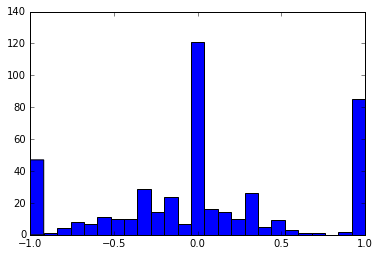

In [42]:
plt.hist( partisan_strength.values(), bins=25)

Let's take a look at the centrality of the first, say, 15 bills, to get an idea of our measures.

In [45]:
bill_centrality.items()[1:15]

[(u'sres57', 0.06138205876624768),
 (u'sres55', 0.31829512118517544),
 (u'sres132', 0.21221851285692134),
 (u'sres133', 0.1899800519432742),
 (u'sres130', 0.8587806671180018),
 (u'sres131', 0.43461861128464463),
 (u'sres137', 0.4300293631983389),
 (u'sres135', 0.20270825615885113),
 (u's304', 0.2106954296661046),
 (u's204', 4.357527429376466),
 (u's55', 0.1876143280557065),
 (u'sres27', 1.3539945542277276),
 (u'sres26', 2.0403988227318015),
 (u's1116', 0.1781069279031517)]

Let's rank these bills and see what the most central bills are

In [47]:
dfBills = pd.concat([dfBills, pd.Series(bill_centrality, name="centrality")], axis=1)
dfBills['centrality_rank'] = dfBills['centrality'].rank(ascending=0)
dfBills.sort_values('centrality_rank').head(10)

,primary_subject,sponsor_id,sponsor_party,title,centrality,centrality_rank,centrality
sres254,Congress,M000355,R,"A resolution relative to the death of Pietro ""...",9.737875,3,9.737875
sres292,Crime and Law Enforcement,H001041,R,A resolution condemning the brutal and sensele...,9.737875,3,9.737875
sres193,Congress,K000384,D,A resolution commending the bravery of the Uni...,9.737875,3,9.737875
s1616,Congress,R000307,R,A bill to award the Congressional Gold Medal t...,9.737875,3,9.737875
sres184,Congress,M000355,R,A resolution relative to the death of James Pa...,9.737875,3,9.737875
s1182,Finance and Financial Sector,Y000064,R,A bill to require the Secretary of the Treasur...,7.953699,6,7.953699
sres6,International Affairs,R000595,R,A resolution objecting to United Nations Secur...,7.910253,7,7.910253
sres173,Crime and Law Enforcement,G000386,R,A resolution designating the week of May 15 th...,6.909387,8,6.909387
s1598,Armed Forces and National Security,I000055,R,"A bill to amend title 38, United States Code, ...",6.754400,9,6.754400
s722,International Affairs,C001071,R,A bill to impose sanctions with respect to Ira...,6.583159,10,6.583159


And the least central?

In [48]:
dfBills.sort_values('centrality_rank').tail(10)

,primary_subject,sponsor_id,sponsor_party,title,centrality,centrality_rank,centrality
sres4,Congress,M000355,R,A resolution to constitute the majority party'...,0.061382,454.5,0.061382
sconres1,Congress,M000355,R,A concurrent resolution extending the life of ...,0.061382,454.5,0.061382
sres16,Congress,M000355,R,A resolution to constitute the majority party'...,0.061382,454.5,0.061382
sres7,Congress,M000355,R,A resolution to constitute the majority party'...,0.061382,454.5,0.061382
s1848,International Affairs,C001071,R,An original bill to amend the Trafficking Vict...,0.060952,461.5,0.060952
s371,International Affairs,C001071,R,A bill to make technical changes and other imp...,0.060952,461.5,0.060952
sres210,International Affairs,C001071,R,A resolution to correct the engrossment of S. ...,0.060952,461.5,0.060952
s1631,International Affairs,C001071,R,A bill to authorize the Department of State fo...,0.060952,461.5,0.060952
sres62,Congress,S000320,R,An original resolution authorizing expenditure...,0.056312,464.5,0.056312
s1662,Economics and Public Finance,S000320,R,An original bill making appropriations for the...,0.056312,464.5,0.056312
